In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import argrelextrema
from tqdm.notebook import tqdm
import mplfinance as mpf

import sys

sys.path.insert(0,'/Users/orentapiero/btc_research/')

from btc_functions.glassnode import *
from btc_functions.import_data import get_glassnode_price,get_glassnode_data
from btc_functions.variable_list_urls import *
from btc_functions.utilities import strided_app,strided_app2

plt.rcParams['figure.figsize'] = [18, 10]
sns.set()

In [40]:
def bar_create(ohlc,what = 'transfers_volume_sum',th=5):
    df = ohlc.copy()
    group = pd.Series(index = df.index, dtype = float, name = 'group')
    N = len(group)

    t = ohlc[what] #100*np.log(ohlc['Close']/ohlc['Open'])
    ts = 0
    idx = []

    for i, x in enumerate(t):
        ts += x
        if np.abs(ts) > th:
            idx.append(i)
            ts = 0.0
            continue

    group.iloc[idx]  = idx
    group.fillna(method = 'bfill',inplace = True)
    group.fillna(method = 'ffill',inplace = True)

    df.loc[:,'group'] = group
    df.loc[:,'Time'] = df.index

    fTime = df.groupby('group')['Time'].first()
    lTime = df.groupby('group')['Time'].last()
    Time_ = pd.concat([fTime,lTime],axis = 1)
    Time_.columns = ['open','close']
    Time_.index = Time_.close
    Time_.loc[:,'dt'] = (Time_.close-Time_.open).dt.total_seconds()


    Open = df.groupby('group')['Open'].first()
    High = df.groupby('group')['High'].max()
    Low = df.groupby('group')['Low'].min()
    Close = df.groupby('group')['Close'].last()

    newOhlc = pd.concat([Open,High,Low,Close],axis = 1)
    newOhlc.index = lTime
    return newOhlc,group


In [17]:
from scipy.stats import mode

def roll_mode(price,L):
    st_pr = strided_app(price.values,L,1)
    m = np.empty_like(price.values)
    m[:] = np.nan
    
    m[(L-1):] = [mode(st_pr[t,:])[0][0] for t in range(st_pr.shape[0])]
    m = pd.Series(m,index = price.index)
    return m

In [49]:
ohlc = get_glassnode_price()
ohlc = ohlc.rename(columns = {'o':'Open','h':'High','l':'Low','c':'Close'})
ohlc = ohlc.loc[:'2019']
ohlc['win'] = np.sign(ohlc.Close-ohlc.Open)

newOhlc,group = bar_create(ohlc,what = 'win',th=2)

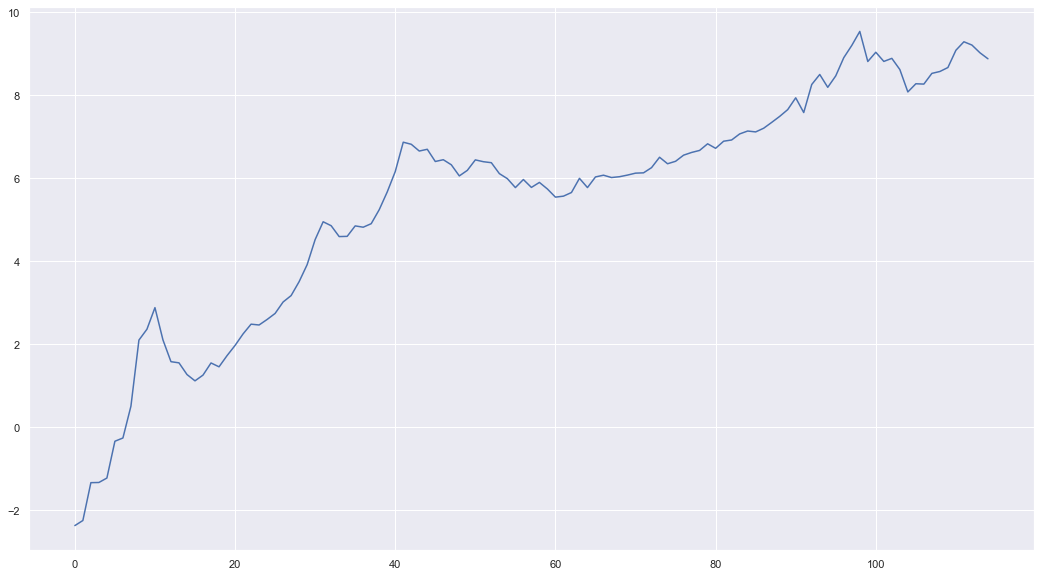

In [48]:
plt.plot(np.log(newOhlc.Close).values)

In [43]:
ohlc

,Close,High,Low,Open,win
t,,,,,
2010-07-17,0.049510,0.049510,0.049510,0.049510,0.0
2010-07-18,0.085840,0.085850,0.059410,0.059410,1.0
2010-07-19,0.080800,0.093070,0.078550,0.090900,-1.0
2010-07-20,0.074733,0.081810,0.074260,0.081810,-1.0
2010-07-21,0.079210,0.079210,0.066340,0.074250,1.0
...,...,...,...,...,...
2019-12-27,7295.607233,7360.808324,7198.945254,7236.234857,1.0
2019-12-28,7319.890849,7392.303528,7290.127838,7291.115853,1.0
2019-12-29,7419.179415,7511.106510,7279.865468,7279.865468,1.0
